# Домашнее задание "Временные ряды, общая теория" (Знакомство с временными рядами)

***Цель:***
    Проанализировать временные ряды, сделать их стационарными.

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
sales = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines = pd.read_csv("Series/international-airline-passengers.csv")
temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

Напишем несколько функций, чтобы проанализировать данные и не дублировать 6 раз код:

Итак, функция общего ознакомления с фреймом:

In [3]:
def all_info(df, column_date):
    print(df.head)
    print()
    print(df.info())
    print()
    # подготовка к работе:
    df['Datetime'] = pd.to_datetime(df['{}'.format(column_date)])
    df = df.set_index('Datetime')
    df = df.drop(['{}'.format(column_date)], axis=1)

    # Теперь разложим ряд на тренд,  сезонную компоненту и остаток.

    decomposed = seasonal_decompose(df)

    plt.figure(figsize=(6, 8))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()
    plt.show()
    return df

Далее: для графика Дики-Фуллера и графиков коррелограмм:

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Теперь функция для нахождения скользящего среднего и скользящего стандартного отклонения:

In [5]:
def sliding(df, column):
    # сделаем поиск разностей временного ряда:
    df_1 = pd.DataFrame()
    df_1[column] = df[column] - sales[column].shift(fill_value=0)

    # вычислим скользящее среднее с окном 15 и агрегируем значения с помощью усреднения. Запишем в новый столбец:
    df_1['mean'] = df_1.rolling(15).mean().fillna(0)

    # и то же самое, только для скользящего стандартного отклонения:
    df_1['std'] = df_1[column].rolling(15).std().fillna(0)
    df_1[[column, 'mean', 'std']].plot()
    return df_1

Теперь функция, убирающая тренд или сезонность:

In [6]:
def tr_seas_alignment(df, column, todo):
    if todo == 'тренд':
    # убираем тренд:
        return df[column].values[1:] - df[column].values[:-1]
    if todo == 'сезонность':
    # убираем сезонность:
        return df[column].values[12:] - df[column].values[:-12]

Приступим к датафреймам:

***Sales***

<bound method NDFrame.head of       Month  Count
0   1965-01    154
1   1965-02     96
2   1965-03     73
3   1965-04     49
4   1965-05     36
..      ...    ...
72  1971-01    628
73  1971-02    308
74  1971-03    324
75  1971-04    248
76  1971-05    272

[77 rows x 2 columns]>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   77 non-null     object
 1   Count   77 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ KB
None



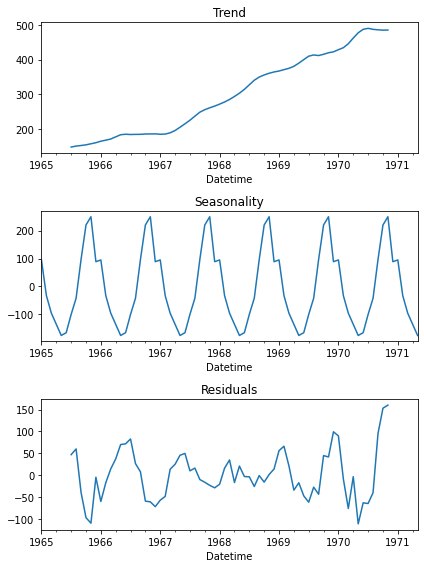

In [7]:
s = all_info(sales, 'Month')

Тренд есть, сезонность также есть, остатки в наличии и они хаотичны.  
Что скажут коррелограммы?

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\ProgramData\Anaconda3\envs\scientificProject\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


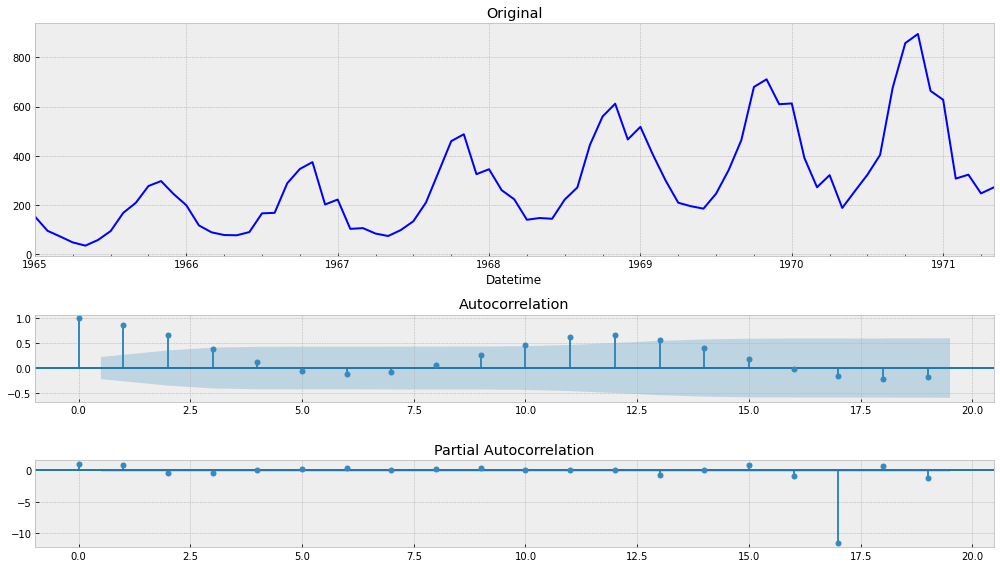

In [8]:
tsplot(s['Count'])

Попробуем убрать изменение дисперсии при помощи преобразования Бокса-Кокса:

Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\ProgramData\Anaconda3\envs\scientificProject\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


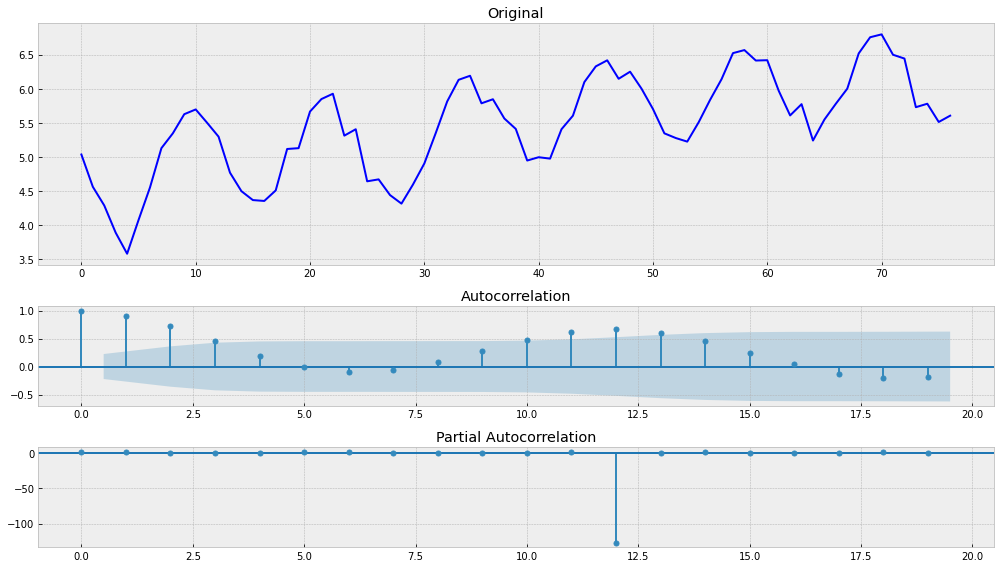

In [9]:
s_new = boxcox(s['Count'], 0)
tsplot(s_new)

Разброс действительно стал меньше, но p-value еще слишком высокое, поэтому отвергнуть гипотезу о нестационарности ряда мы не можем. Тренд еще есть, нужно его убрать:

Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


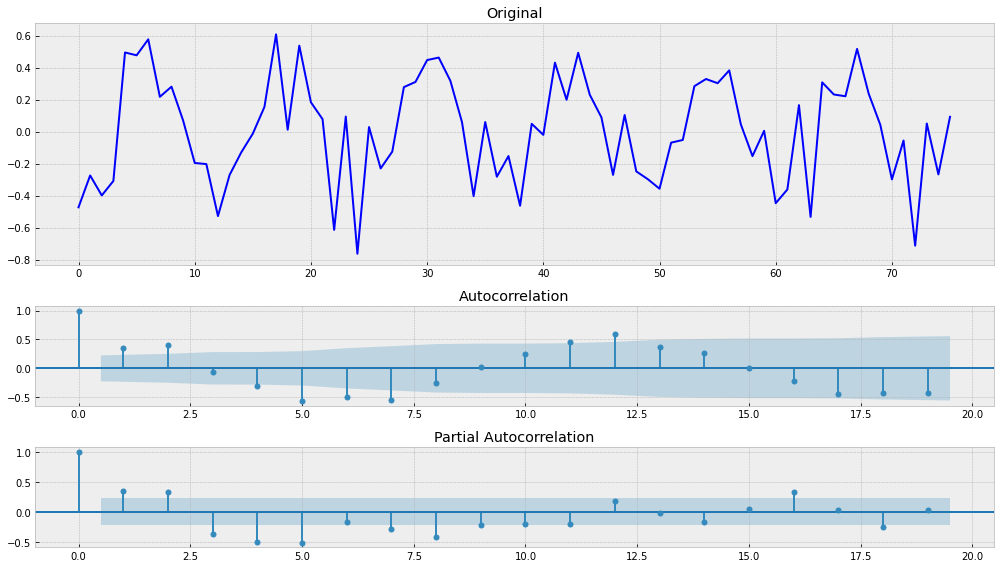

In [10]:
tsplot(s_new[1:] - s_new[:-1])

А что, если посмотреть на скользящее среднее и скользящее стандартное отклонение?

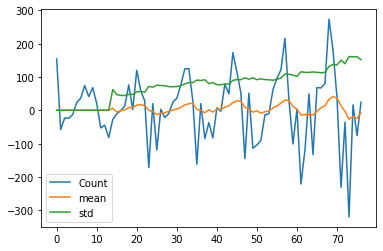

In [11]:
s_new_2 = sliding(sales, 'Count')

Поработаем со стандартным отклонением:

Results of Dickey-Fuller Test:
Test Statistic                 -1.903028
p-value                         0.330638
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\ProgramData\Anaconda3\envs\scientificProject\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


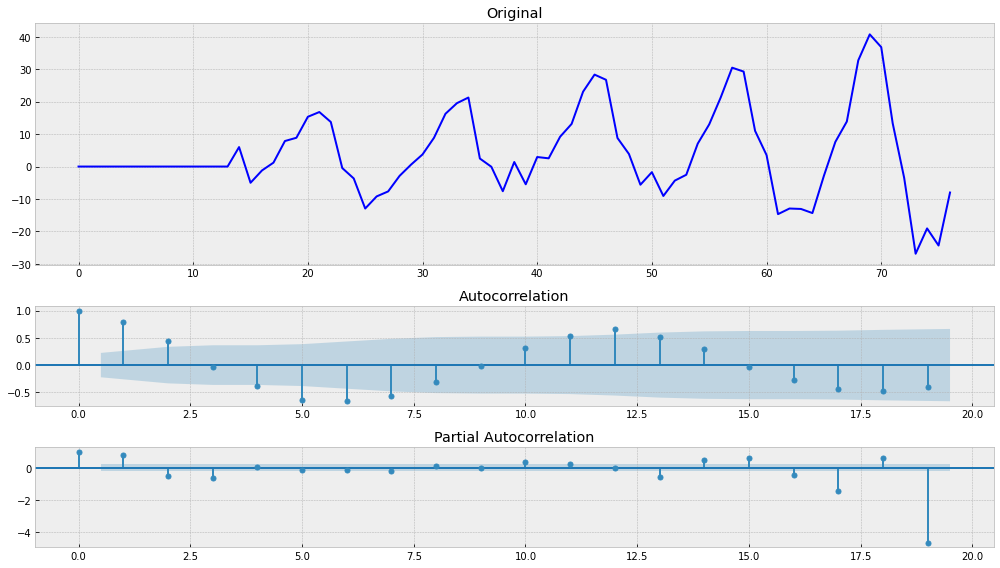

In [12]:
tsplot(s_new_2['mean'])

Видна сезонность. Уберем ее:

Results of Dickey-Fuller Test:
Test Statistic                 -4.901935
p-value                         0.000035
#Lags Used                      3.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


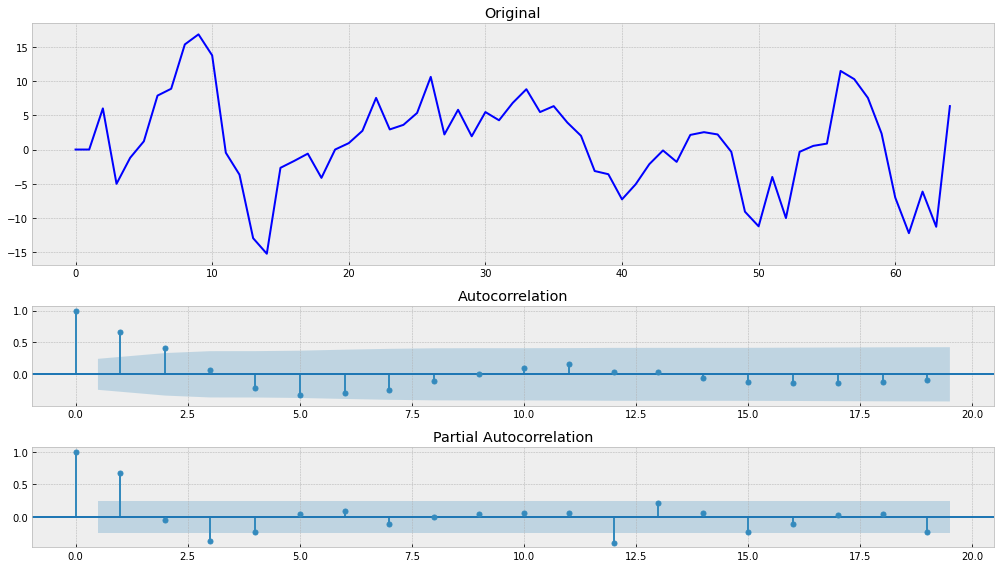

In [13]:
tsplot(tr_seas_alignment(s_new_2, 'mean', 'сезонность'))

Итак, получившееся p-value позволяет отвергнуть нулевую гипотезу о нестационарности ряда.  
Но у нас есть еще скользящее стандартное отклонение:

Results of Dickey-Fuller Test:
Test Statistic                 -0.675330
p-value                         0.853037
#Lags Used                      1.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


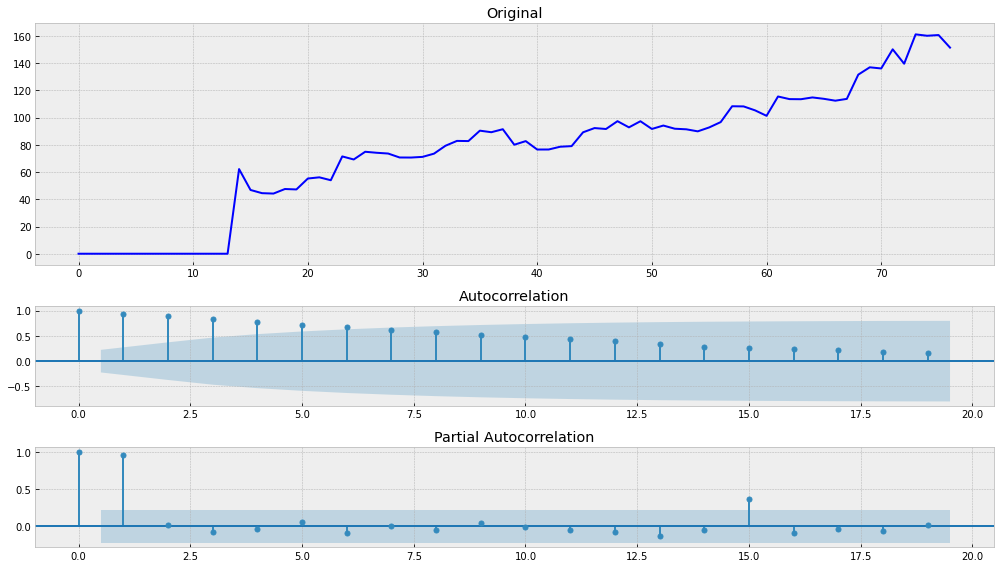

In [14]:
tsplot(s_new_2['std'])

А здесь есть тренд.

Results of Dickey-Fuller Test:
Test Statistic                -1.130216e+01
p-value                        1.299484e-20
#Lags Used                     0.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


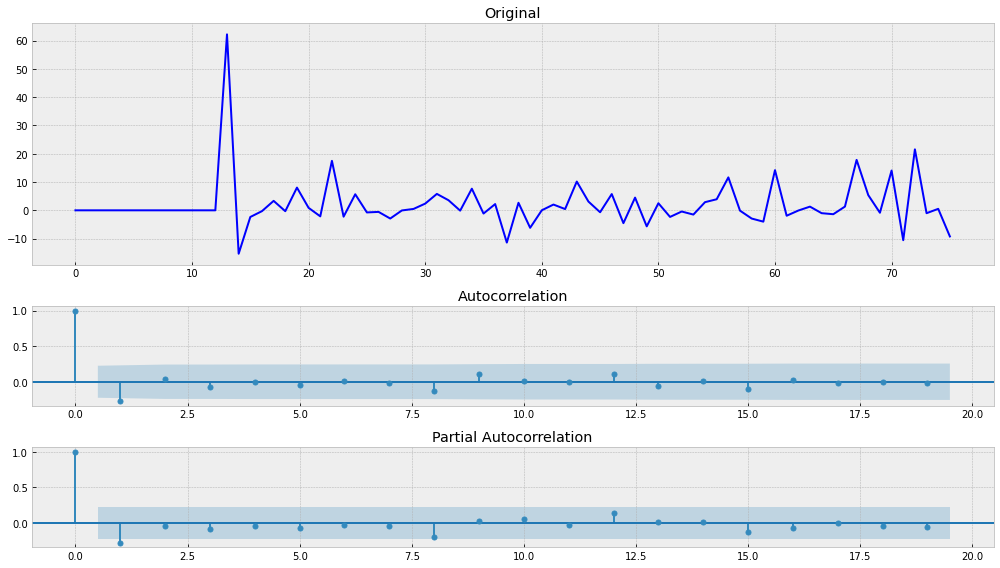

In [15]:
tsplot(tr_seas_alignment(s_new_2, 'std', 'тренд'))

Таким образом, p-value = 0.00000000000000000001. Это еще более убедительный результат, позволяющий в этом случае, на конкретном наборе данных отколнить нулевую гипотезу о нестационарности ряда. Тем не менее, не будем забывать о том, что при другом наборе данных или при бОльшем количестве данных результат мог бы быть иным.

In [16]:
del s, s_new, s_new_2

Переходим к датафрейму robberies (Ежемесячные вооруженные ограбления в Бостоне):

***robberies:***

<bound method NDFrame.head of        Month  Count
0    1966-01     41
1    1966-02     39
2    1966-03     50
3    1966-04     40
4    1966-05     43
..       ...    ...
113  1975-06    316
114  1975-07    398
115  1975-08    394
116  1975-09    431
117  1975-10    431

[118 rows x 2 columns]>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   118 non-null    object
 1   Count   118 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ KB
None



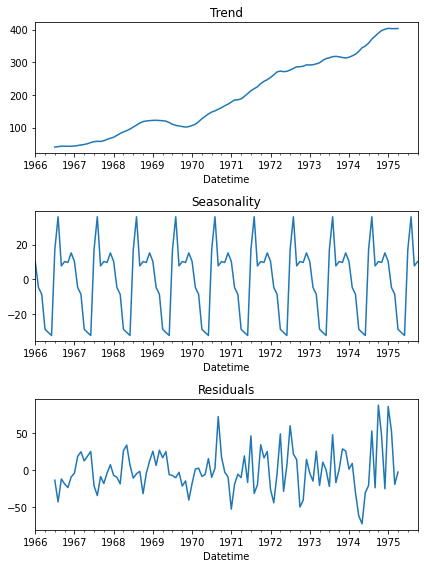

In [17]:
r = all_info(robberies, 'Month')

Итак, снова есть сезонность и тренд. Остатки также хаотичны.

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


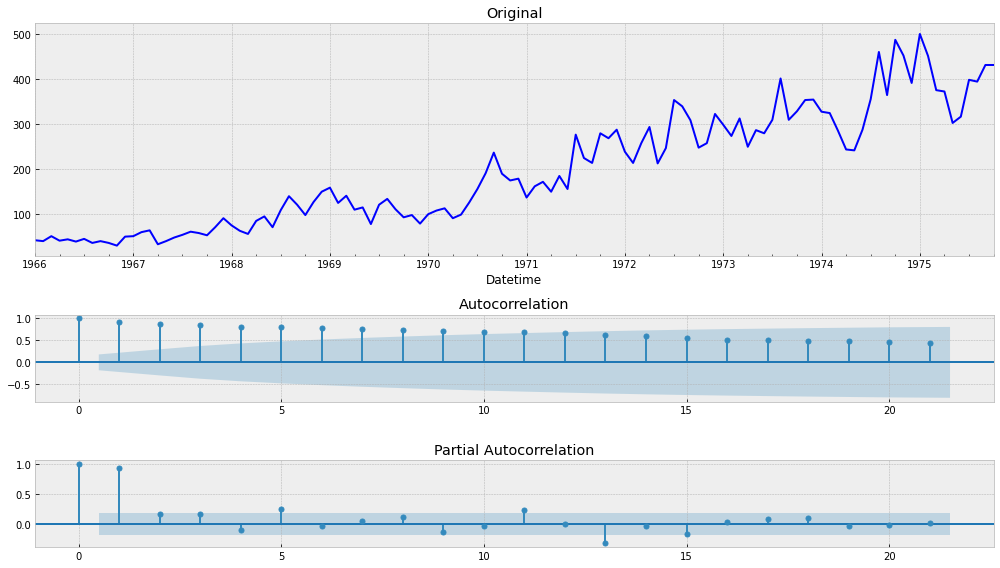

In [18]:
tsplot(r['Count'])

p-value велико. У графиков прослеживается тренд и сезонность.

Применяем преобразование Бокса-Кокса:

Results of Dickey-Fuller Test:
Test Statistic                  -2.013161
p-value                          0.280833
#Lags Used                      10.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


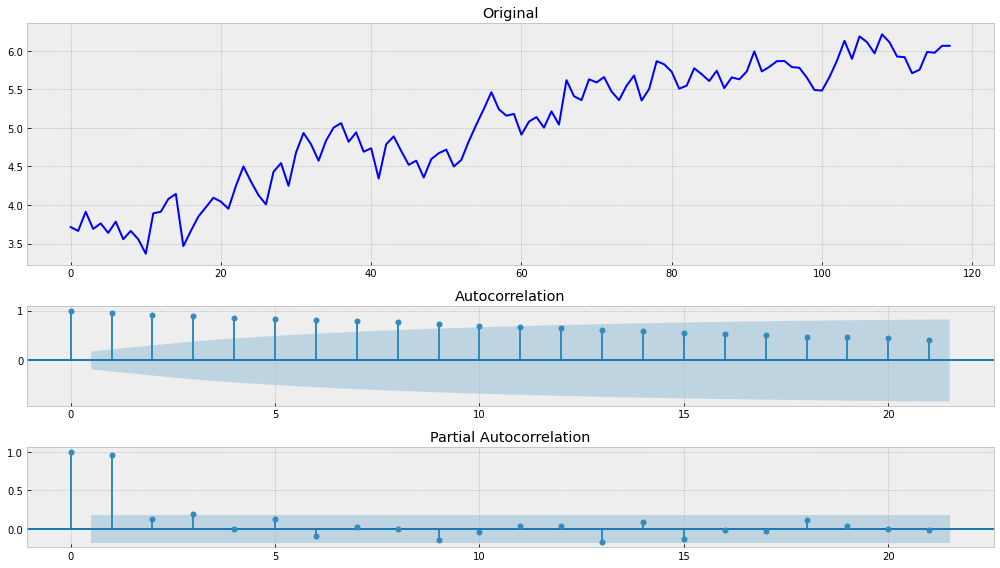

In [19]:
tsplot(boxcox(r['Count'], 0))

Всё равно есть как минимум тренд. Чтобы сделать ряд более стационарным, уберем тренд:

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


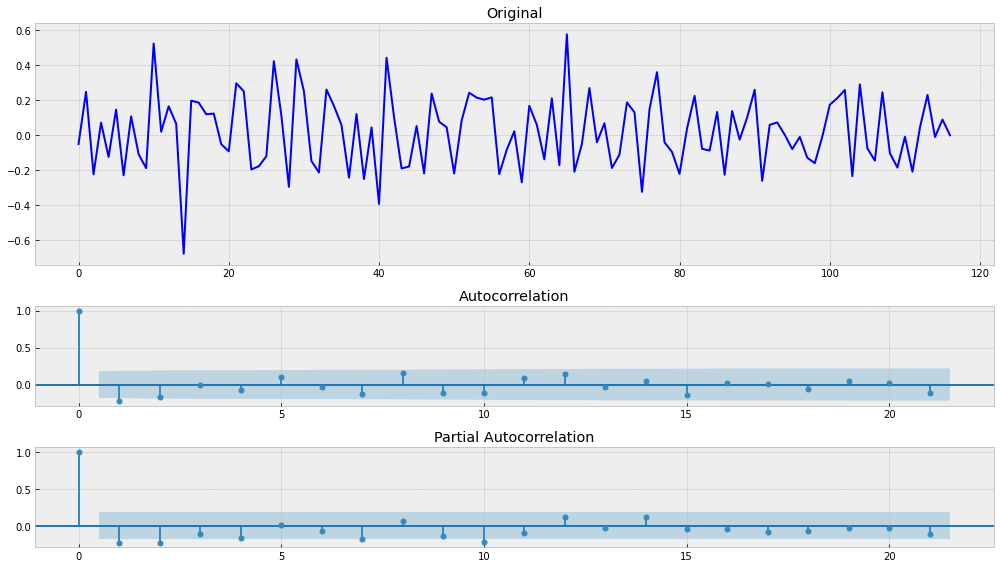

In [20]:
tsplot(boxcox(r['Count'], 0)[1:] - boxcox(r['Count'], 0)[:-1])

Итак, p_value = 0.00000000002378602. Гипотезу о нестационарности ряда можно отвергать.

***Airlines:***

<bound method NDFrame.head of        Month  Count
0    1949-01    112
1    1949-02    118
2    1949-03    132
3    1949-04    129
4    1949-05    121
..       ...    ...
139  1960-08    606
140  1960-09    508
141  1960-10    461
142  1960-11    390
143  1960-12    432

[144 rows x 2 columns]>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   144 non-null    object
 1   Count   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None



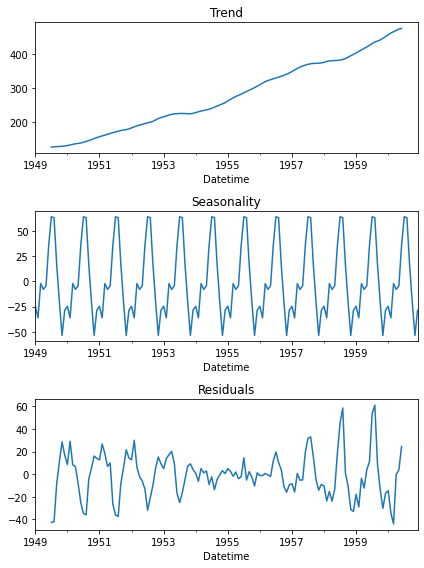

In [21]:
a = all_info(airlines, 'Month')

Суду всё ясно.

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


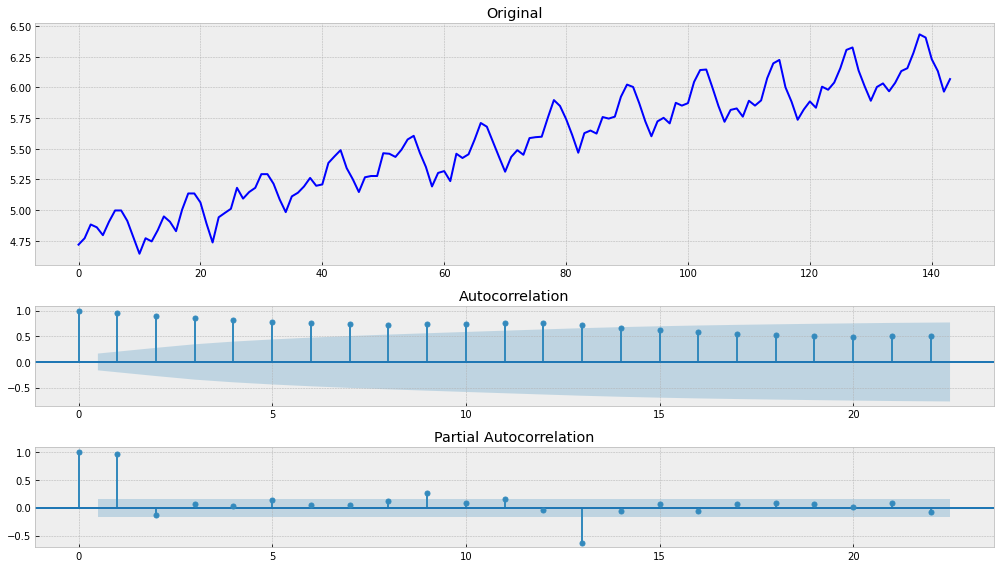

In [22]:
tsplot(boxcox(a['Count'], 0))

И снова тренд:

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


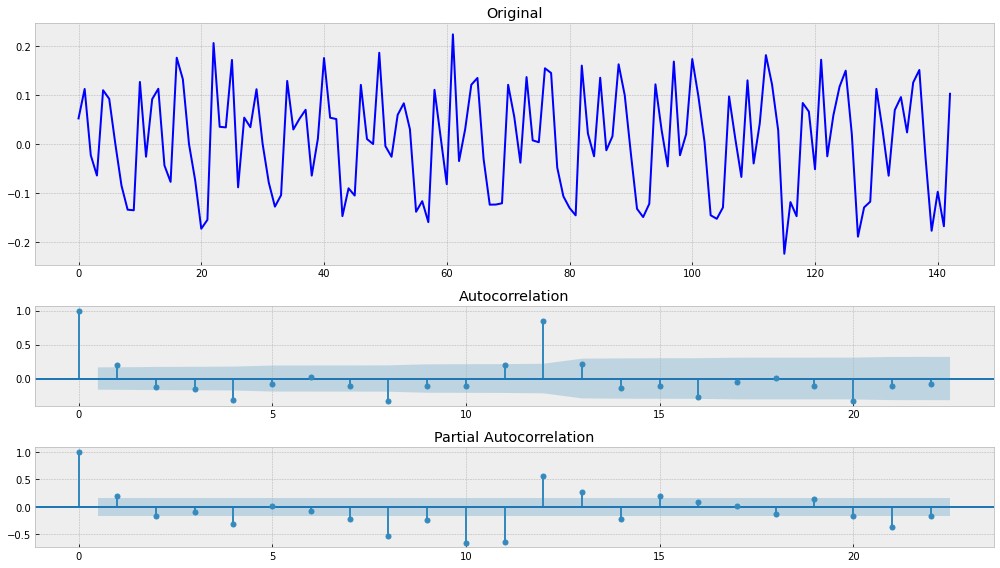

In [23]:
a_trend = boxcox(a['Count'], 0)[1:] - boxcox(a['Count'], 0)[:-1]
tsplot(a_trend)

На графике автокорреляции четко выражена сезонность:

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


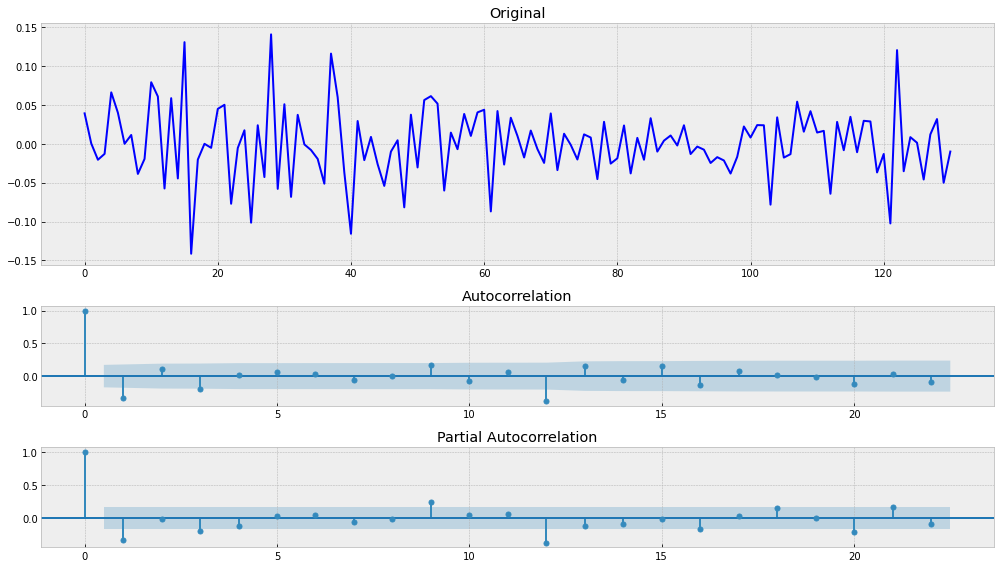

In [24]:
tsplot(a_trend[12:] - a_trend[:-12])

Отлично, но мы можем еще посмотреть на скользящее среднее и стандартное отклонение:

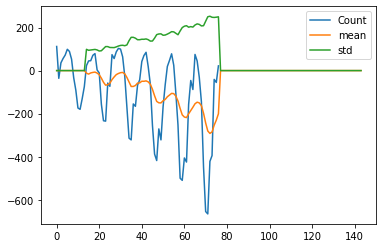

In [25]:
a_new = sliding(airlines, 'Count')

Ряд действительно становится более стационарным, но с ним придется поработать еще. И снова убираем тренд. Начнем со среднего:

Results of Dickey-Fuller Test:
Test Statistic                -6.495209e+00
p-value                        1.199053e-08
#Lags Used                     5.000000e+00
Number of Observations Used    1.370000e+02
Critical Value (1%)           -3.479007e+00
Critical Value (5%)           -2.882878e+00
Critical Value (10%)          -2.578149e+00
dtype: float64


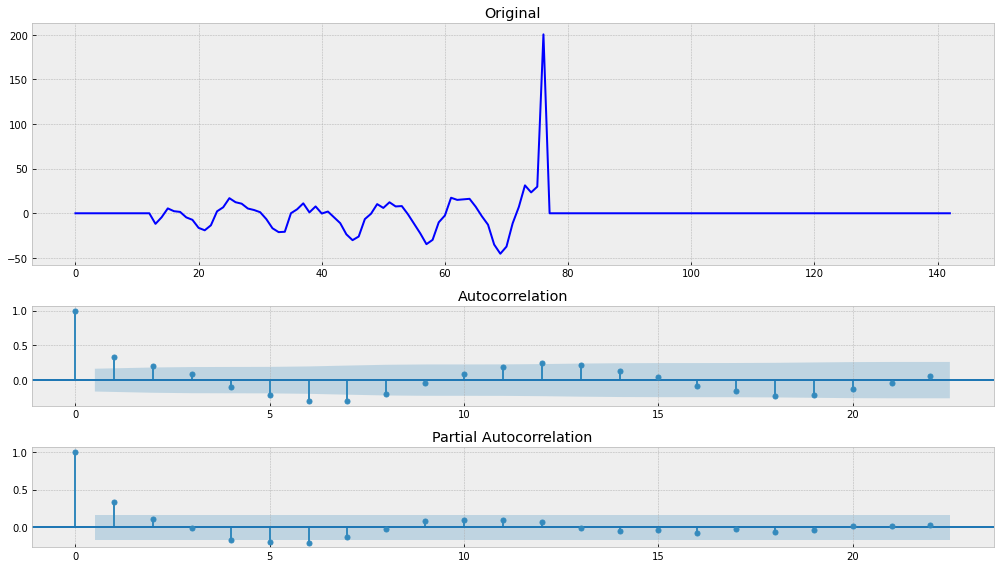

In [26]:
tsplot(tr_seas_alignment(a_new, 'mean', 'тренд'))

p_value = 0.00000001199053. Отлично. Но всё же уберем тренд со столбца со скользящим стандартным отклонением:

Results of Dickey-Fuller Test:
Test Statistic                -1.171166e+01
p-value                        1.484010e-21
#Lags Used                     0.000000e+00
Number of Observations Used    1.420000e+02
Critical Value (1%)           -3.477262e+00
Critical Value (5%)           -2.882118e+00
Critical Value (10%)          -2.577743e+00
dtype: float64


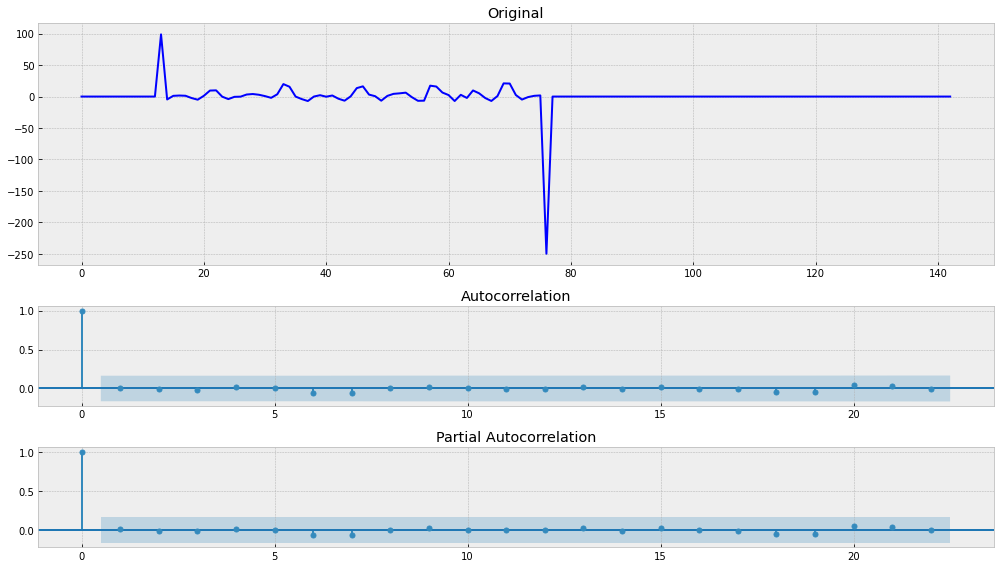

In [27]:
tsplot(tr_seas_alignment(a_new, 'std', 'тренд'))

А здесь значение p стремится к нулю. Однозначно в данном случае выбор пойдет в сторону std. Именно этот столбец можно было бы брать для предсказания в задаче временного ряда.

***Temp:***

<bound method NDFrame.head of        Month   Deg
0    1920-01  40.6
1    1920-02  40.8
2    1920-03  44.4
3    1920-04  46.7
4    1920-05  54.1
..       ...   ...
235  1939-08  61.8
236  1939-09  58.2
237  1939-10  46.7
238  1939-11  46.6
239  1939-12  37.8

[240 rows x 2 columns]>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   240 non-null    object 
 1   Deg     240 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB
None



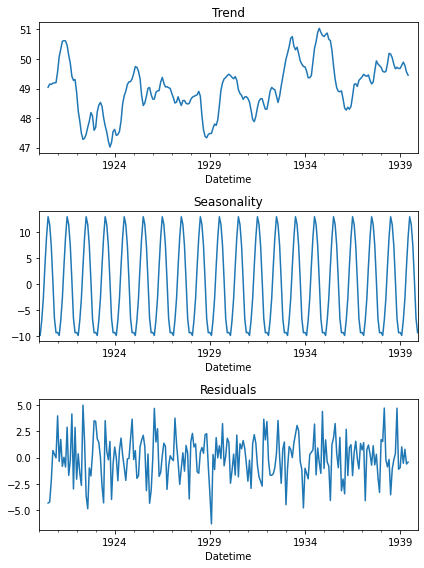

In [28]:
t = all_info(temp, 'Month')

Ярко выраженного тренда здесь нет, зато сезонность присутствует в полной мере. Соответственно, тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда. Снова поработаем над изменением дисперсии при помощи преобразования Бокса-Кокса:

Results of Dickey-Fuller Test:
Test Statistic                  -3.760996
p-value                          0.003333
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


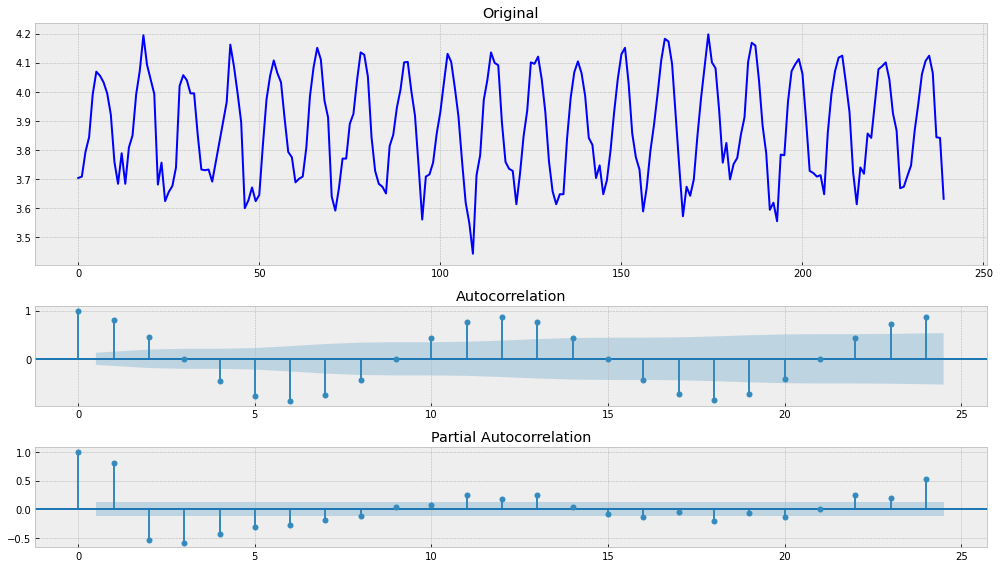

In [29]:
tsplot(boxcox(t['Deg'], 0))

Гипотезу о стационарности ряда можно отвергать, но попробуем еще убрать сезонность, которая очевидна на графиках коррелограмм:

Results of Dickey-Fuller Test:
Test Statistic                -6.411725e+00
p-value                        1.883599e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


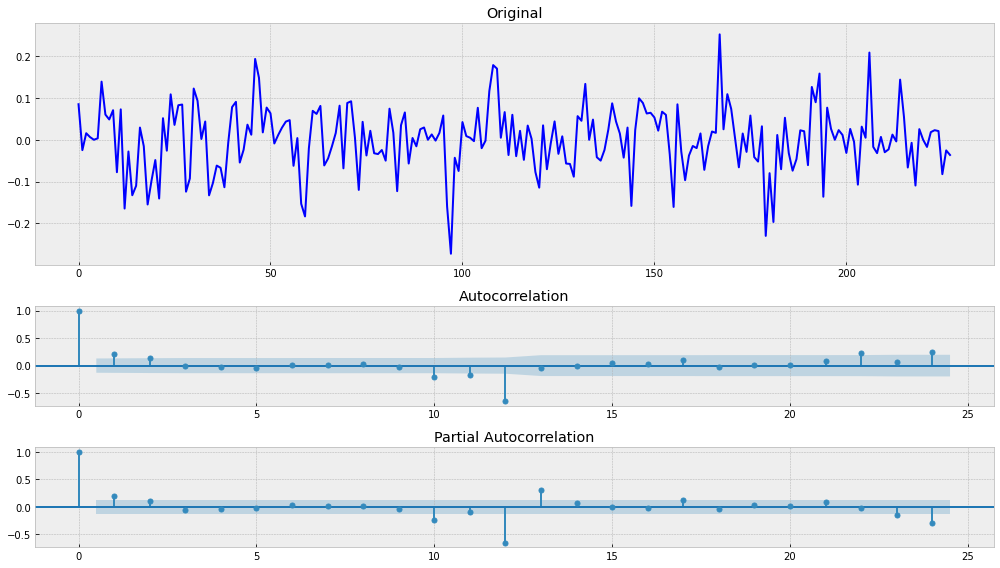

In [30]:
tsplot(boxcox(t['Deg'], 0)[12:] - boxcox(t['Deg'], 0)[:-12])

Отлично! Нулевую гипорезу отвергаем.

***Dowjones:***

In [31]:
dowjones = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
dowjones

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43
...,...,...
157,1974-W28,791.77
158,1974-W29,787.23
159,1974-W30,787.94
160,1974-W31,784.57


Не самое корректное отображение даты и дня недели. При помощи регулярных выражений уберем букву из даты:

In [32]:
dowjones['Date'] = dowjones['Week'].str.replace("W", "")
dowjones

,Week,Close,Date
0,1971-W27,890.19,1971-27
1,1971-W28,901.80,1971-28
2,1971-W29,888.51,1971-29
3,1971-W30,887.78,1971-30
4,1971-W31,858.43,1971-31
...,...,...,...
157,1974-W28,791.77,1974-28
158,1974-W29,787.23,1974-29
159,1974-W30,787.94,1974-30
160,1974-W31,784.57,1974-31


Теперь применим формат даты к новому столбцу:

In [33]:
dowjones['Date'] = pd.to_datetime(dowjones.Date.add('-0'), format='%Y-%W-%w')
dowjones = dowjones.drop('Week', axis=1)   # и столбец с неделей удалим за ненадобностью
dowjones

,Close,Date
0,890.19,1971-07-11
1,901.80,1971-07-18
2,888.51,1971-07-25
3,887.78,1971-08-01
4,858.43,1971-08-08
...,...,...
157,791.77,1974-07-21
158,787.23,1974-07-28
159,787.94,1974-08-04
160,784.57,1974-08-11


Теперь можно анализировать:

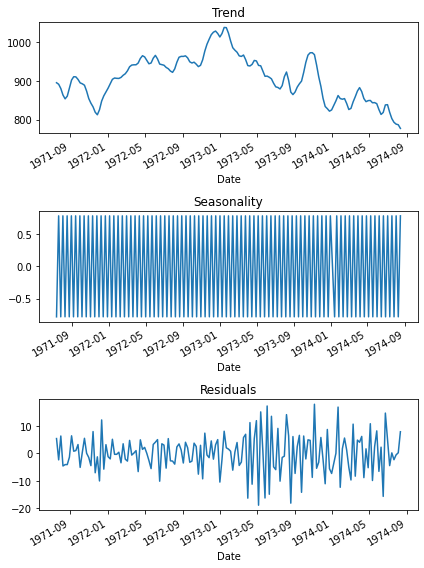

In [34]:
dowjones = dowjones.set_index('Date')

# Разложим ряд на тренд,  сезонную компоненту и остаток.

decomposed = seasonal_decompose(dowjones, period=2)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()

Тренд непонятен (возможно, он волнообразный, но загадывать не будем), зато сезонность явна.

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


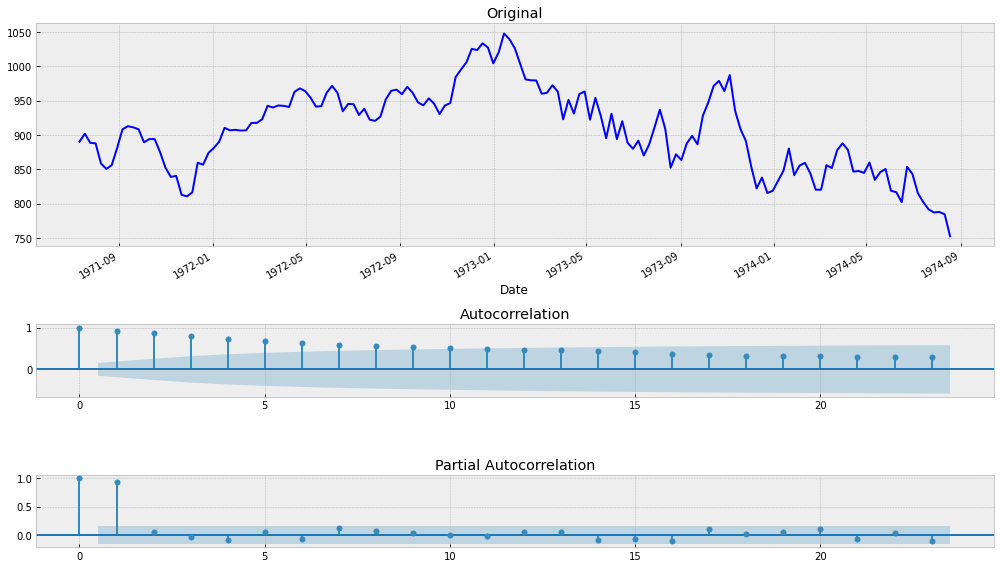

In [35]:
tsplot(dowjones['Close'])

И снова поработаем с дисперсией:

Results of Dickey-Fuller Test:
Test Statistic                  -1.210369
p-value                          0.669119
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


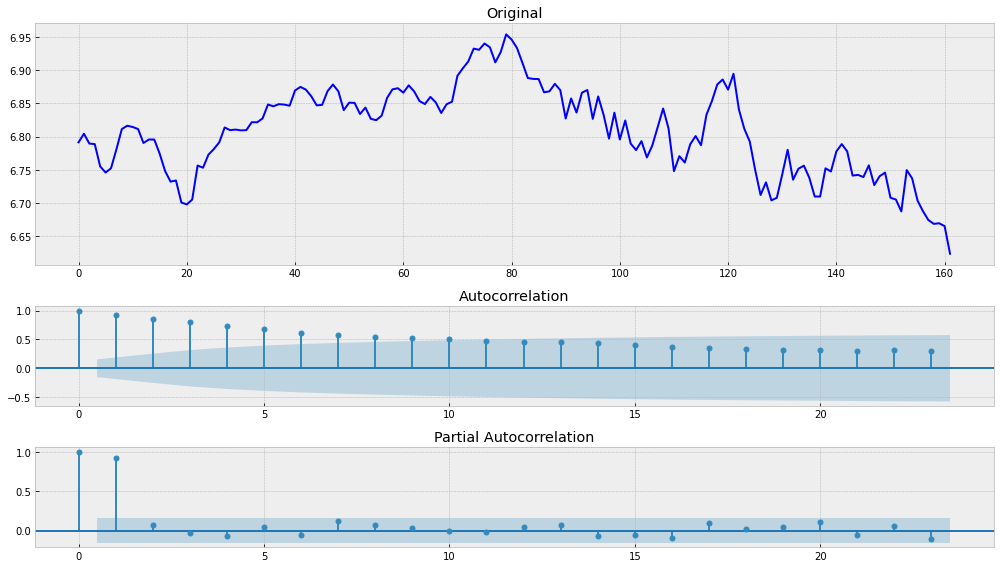

In [36]:
tsplot(boxcox(dowjones['Close'], 0))

Теперь уберем сезонность:

Results of Dickey-Fuller Test:
Test Statistic                  -1.856384
p-value                          0.352849
#Lags Used                      12.000000
Number of Observations Used    137.000000
Critical Value (1%)             -3.479007
Critical Value (5%)             -2.882878
Critical Value (10%)            -2.578149
dtype: float64


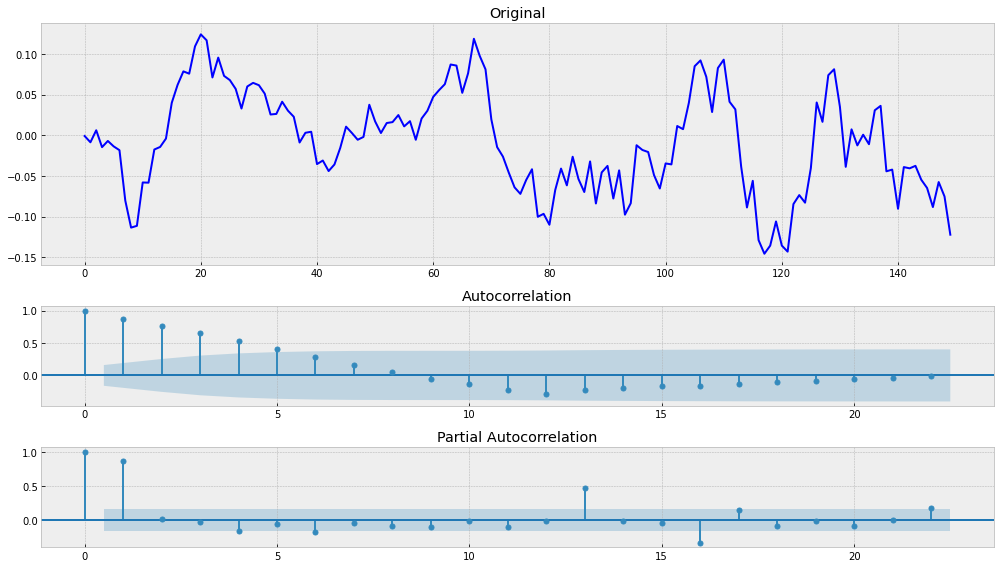

In [37]:
dowjones_seas = boxcox(dowjones['Close'], 0)[12:] - boxcox(dowjones['Close'], 0)[:-12]
tsplot(dowjones_seas)

Предположим, что тренд действительно волнообразный (но для уверенности нам нужно бульше данных):

Results of Dickey-Fuller Test:
Test Statistic                  -3.433413
p-value                          0.009871
#Lags Used                      14.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


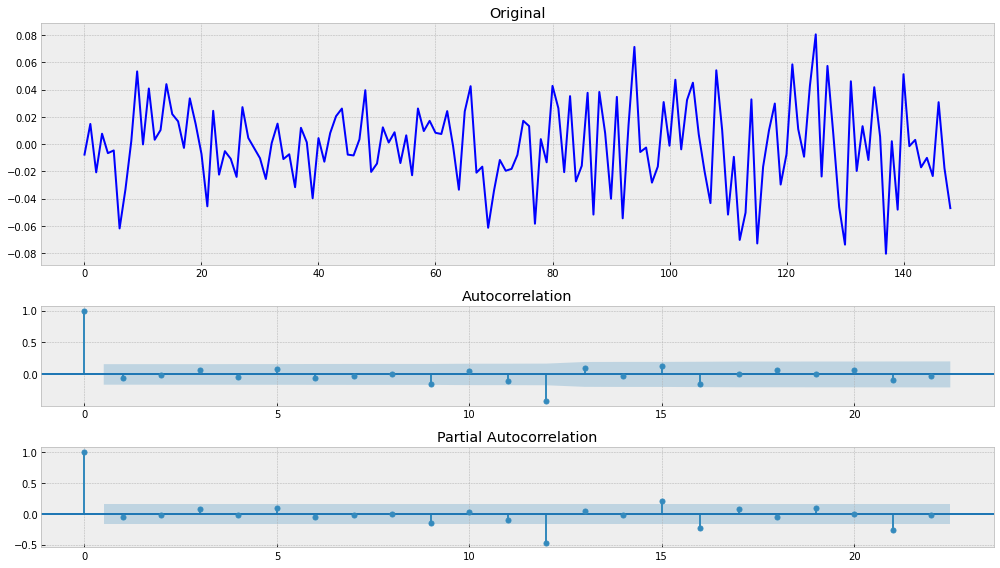

In [38]:
dowjones_seas = boxcox(dowjones['Close'], 0)[12:] - boxcox(dowjones['Close'], 0)[:-12]
tsplot(dowjones_seas[1:] - dowjones_seas[:-1])

Да, теперь нулевую гипотезу можно отвергать.

***Female_births:***

<bound method NDFrame.head of            Date  Count
0    1959-01-01     35
1    1959-01-02     32
2    1959-01-03     30
3    1959-01-04     31
4    1959-01-05     44
..          ...    ...
360  1959-12-27     37
361  1959-12-28     52
362  1959-12-29     48
363  1959-12-30     55
364  1959-12-31     50

[365 rows x 2 columns]>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    365 non-null    object
 1   Count   365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB
None



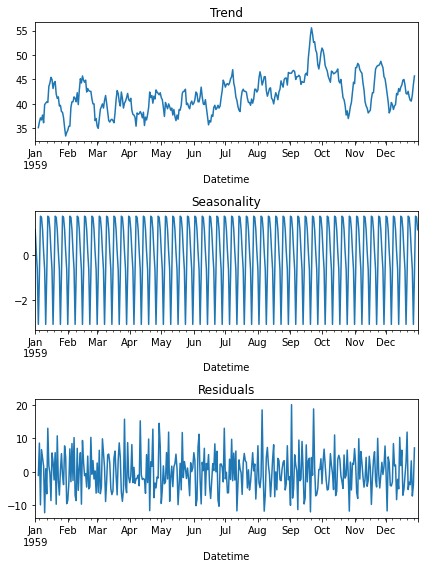

In [39]:
f = all_info(female_births, 'Date')

Тренд не выражен, сезонность есть, остатки пока необъяснимы.

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


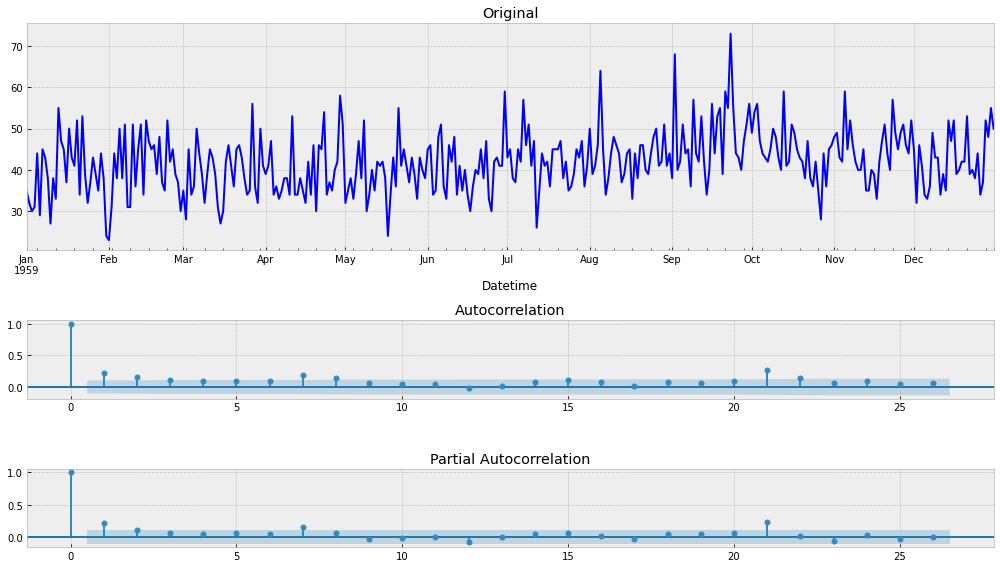

In [40]:
tsplot(f['Count'])

P_value очень небольшое, поэтому гипотезу о нестационарности ряда можно отвергать уже сейчас. Соответственно, этот ряд с самого начала стационарен. Тем не менее, мы можем убрать сезонность и изменить дисперсию, а затем посмотреть, уменьшится ли значение коэффициента значимости:

Results of Dickey-Fuller Test:
Test Statistic                -8.217216e+00
p-value                        6.574680e-13
#Lags Used                     1.200000e+01
Number of Observations Used    3.400000e+02
Critical Value (1%)           -3.449730e+00
Critical Value (5%)           -2.870079e+00
Critical Value (10%)          -2.571319e+00
dtype: float64


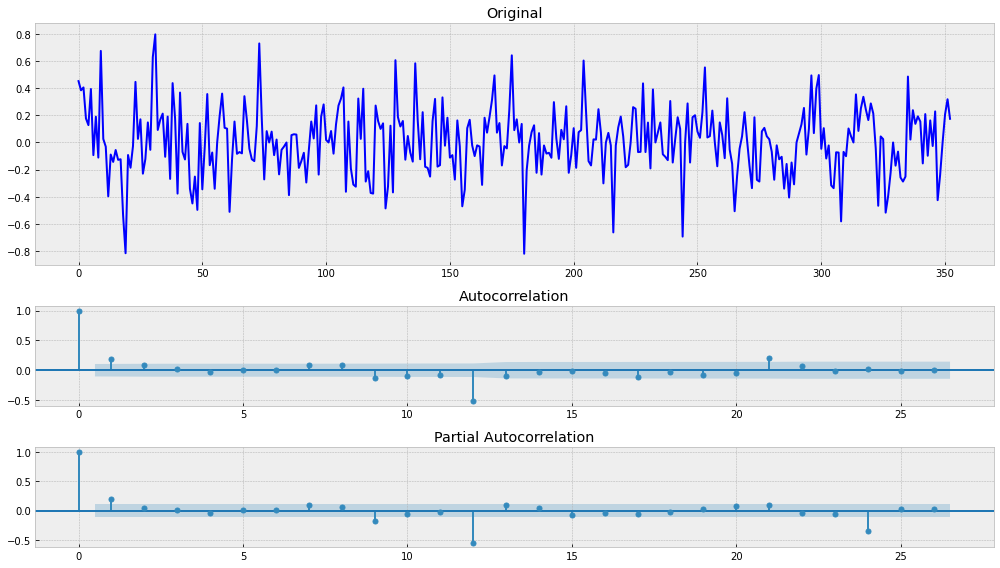

In [41]:
tsplot(boxcox(f['Count'], 0)[12:] - boxcox(f['Count'], 0)[:-12])

P_value = 0.000000000000657468. Действительно, уменьшение дисперсии и влияния сезонности делает ряд более стационарным. Гипотезу о нестационарности можно отвергать.

### Вывод

В данной работе мы анализировали временные ряды и стремились сделать их стационарными. Некоторые ряды, как, например, "Количество ежемесячных продаж в компании X", "Количество пассажиров международных авиакомпаний, тыс" или "Еженедельные закрытия индекса Доу-Джонса" требовали более тщательного анализа и предобработки для придания ряду стационарности. Так, например, для файла с количеством продаж было необходимо расчитать скользящее среднее и скользящее стандартное отклонение для того, чтобы сделать ряд стационарным, а для индекса Доу-Джонса следовало изменить формат предоставления даты (pandas не понимал формат с лишней буквой).  
Другие же ряды, напротив, требовали меньших усилий. Так, например, ряд "Ежедневное общее число родившихся детей женского пола в Калифорнии" ряд уже был стационарным. Тем не менее, сезонность в нем присутствовала, поэтому убрав сезонность, мы достигли прекрасных результатов, позволяющих отвергнуть гипотезу и нестационарности ряда.  
Таким образом, можно сказать, что к каждому ряду данных необходим свой подход, но при должных действиях каждый ряд становится стационарным, а значит, более предсказуемым для моделей, работающих с временными рядами.